This is a revised version of Programming Assignment 2 for CM50270: Reinforcement Learning 

Revision Date: 09/03/2021 <br>
Reason for Revision: Student Feedback

Changes from the original version:
- Total time limit increased from 8 minutes to 10 minutes. 
- Minimum number of agents averaged in Exercise 5 decreased from 20 to 2.

# CM50270 Reinforcement Learning
## Coursework Part 2: Racetrack

In this exercise, you will implement and compare the performance of three reinforcement learning algorithms: On-Policy First-Visit Monte-Carlo Control, Sarsa, and Q-Learning.

**Total number of marks:** 40 marks.

**What to submit:** Your completed Jupyter notebook (.ipynb file) which should include **all** of your source code. Please **do not change the file name or compress/zip your submission**. Please do not include any identifying information on the files you submit. This coursework will be marked **anonymously**.

**Where to submit:** CM50270 Moodle Page.

You are required to **work individually**. You are welcome to discuss ideas with others but you must design your own implementation and **write your own code**.

**Do not plagiarise**. Plagiarism is a serious academic offence. For details on what plagiarism is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

If you are asked to use specific variable names, data-types, function signatures and notebook cells, **please ensure that you follow these instructions**. Not doing so will cause the automarker to reject your work, and will assign you a score of zero for that question. **If the automarker rejects your work because you have not followed the instructions, you may not get any credit for your work**.

Please **do not use any non-standard, third-party libraries** apart from numpy and matplotlib. In this part of the coursework, you should also use the `racetrack_env` file, which we have provided for you. **If we are unable to run your code because you have used unsupported external libraries, you may not get any credit for your work.**

Please remember to **save your work regularly**.

Please be sure to **restart the kernel and run your code from start-to-finish** (Kernel → Restart & Run All) before submitting your notebook. Otherwise, you may not be aware that you are using variables in memory that you have deleted.

Your total runtime must be less than **10 minutes** on the University's computers, and **written answer length limits** must be adhered to. Otherwise, you may not get credit for your work. You can run your code on the university's computers remotely using [UniDesk](https://bath.topdesk.net/tas/public/ssp/content/detail/knowledgeitem?unid=ff3266344c1d4eb2acb227cc9e3e1eee)

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of coursework. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode in a randomly selected  grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


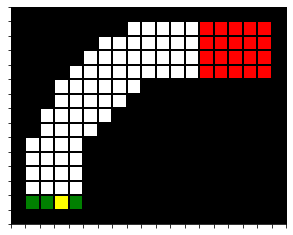

Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

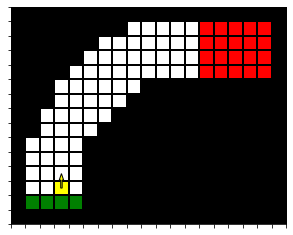

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [2]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

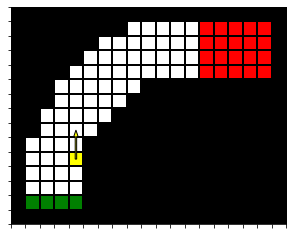

In [3]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise 1: On-Policy MC Control (8 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using On-Policy First-Visit MC Control, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 5.4 p.101).

<img src="images/mc_control_algo.png" style="width: 650px;"/>

Please produce the following:
- A tabular **On-Policy First-Visit MC Control agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

-----------------
[-4244.133333333333, -6219.733333333334, -7429.933333333333, -4214.166666666667, -6274.466666666666, -4240.833333333333, -2778.0666666666666, -2195.733333333333, -1402.8333333333333, -1455.5, -1309.2666666666667, -1275.9333333333334, -1652.8333333333333, -1636.9666666666667, -1786.5333333333333, -1631.7333333333333, -916.9333333333333, -1021.4, -780.8666666666667, -1343.3, -503.73333333333335, -609.5, -655.7333333333333, -523.5, -555.4333333333333, -448.1, -637.0333333333333, -402.8333333333333, -972.8666666666667, -445.46666666666664, -287.1333333333333, -166.5, -282.06666666666666, -343.43333333333334, -315.6333333333333, -367.3333333333333, -423.53333333333336, -326.23333333333335, -308.8, -307.3, -481.46666666666664, -480.6333333333333, -302.53333333333336, -327.7, -255.63333333333333, -320.43333333333334, -205.76666666666668, -176.03333333333333, -155.9, -154.33333333333334, -239.33333333333334, -200.8, -215.53333333333333, -191.4, -143.63333333333333, -199.13333

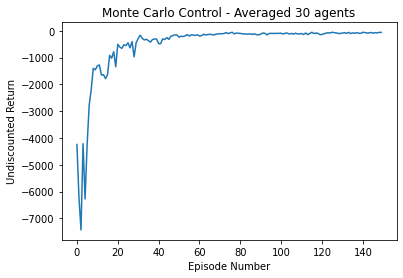

In [4]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent and plot your average learning curve here.
# Do NOT delete this cell.

# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent and plot your average learning curve here.
# Do NOT delete this cell.

# YOUR CODE HERE
import numpy as np
from racetrack_env import RacetrackEnv
from typing import List
from collections import defaultdict


def argmax(values: list) -> int:
    # np.argmax returns the first element in a list with the max value.
    # We dont want this. we want to get a random choice of this max val.
    max_val = max(values)
    actions = [a for a in range(len(values)) if values[a] == max_val]
    return np.random.choice(actions)


class EpsilonGreedyPolicy:
    def __init__(self, actions: List[int], epsilon: float) -> None:
        self._actions = actions
        self.mapping = defaultdict(lambda: [0 for _ in self._actions])
        self.epsilon = epsilon

    def __call__(self, state: int) -> int:
        """
        Returns the optimal choice with probability of 1-epsilon. Else random.
        """
        probabilities = [(self.epsilon / len(self._actions)) for _ in self._actions]
        greedy_action = argmax(self.mapping[state])
        probabilities[greedy_action] += (1 - self.epsilon)
        return np.random.choice(self._actions, p=probabilities)


class OnPolicyMCControl:
    def __init__(self, env, epsilon, gamma, num_episodes):
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.positions = len(env.track) * len(env.track[0])
        self.Q = defaultdict(lambda: [0 for _ in self.env.get_actions()])
        self.policy = EpsilonGreedyPolicy(env.get_actions(), epsilon)

    def _do_episode(self, episode_num):
        state = self.env.reset()
        episode = []
        while True:  # Loop forever for each episode.
            action = self.policy(state)
            next_state, reward, is_terminal = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if is_terminal:
                break

        return episode

    def start(self):
        returns = defaultdict(lambda: [[] for _ in self.env.get_actions()])
        undiscounted_returns = []
        for episode_num in range(self.num_episodes):
            episode = self._do_episode(episode_num)
            G = 0
            undiscounted_return = 0
            s_a_episode = [(s, a) for s, a, _ in episode]
            for t, (s, a, r) in enumerate(reversed(episode)):
                G = self.gamma * G + r
                undiscounted_return += r
                if (s, a) in s_a_episode[:t]:
                    continue

                returns[s][a].append(G)
                self.Q[s][a] = sum(returns[s][a]) / len(returns[s][a])
                a1 = argmax(self.Q[s])

                for a_ in self.env.get_actions():
                    if a_ == a1:
                        self.policy.mapping[s][a_] = 1 - self.epsilon + self.epsilon / len(self.env.get_actions())
                    else:
                        self.policy.mapping[s][a_] = self.epsilon / len(self.env.get_actions())
            undiscounted_returns.append(undiscounted_return)
        return undiscounted_returns


num_agents = 30
epsilon = 0.15  # chance of doing something random
gamma = 0.9  # discount
num_episodes = 150
optimal_policies = []
agents_rewards_list = []
for i in range(num_agents):
    env = RacetrackEnv()
    agent = OnPolicyMCControl(env, epsilon, gamma, num_episodes)
    rewards = agent.start()
    agents_rewards_list.append(rewards)

mean_agent_rewards = []
for i in range(num_episodes):
    sum_i = 0
    for agent_rewards in agents_rewards_list:
        sum_i += agent_rewards[i]
    reward_avg = sum_i / num_agents
    mean_agent_rewards.append(reward_avg)

print('-----------------')
print(mean_agent_rewards)
ex1_results = mean_agent_rewards

import matplotlib.pyplot as plt
plt.plot(mean_agent_rewards)
plt.title(f"Monte Carlo Control - Averaged {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.show()

## Exercise 2: Sarsa (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Sarsa algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.4 p.129).

<img src="images/sarsa_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Sarsa agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

-----------------
[-2455.6, -1859.8666666666666, -1231.8666666666666, -1417.2, -1400.1333333333334, -1218.8, -1110.0333333333333, -731.8, -1270.6333333333334, -555.6, -1165.9333333333334, -564.9333333333333, -988.2, -614.8666666666667, -557.0, -632.3333333333334, -718.2666666666667, -612.3333333333334, -696.0666666666667, -479.8, -504.6333333333333, -733.7, -372.3, -534.9, -327.7, -673.8, -468.3666666666667, -409.03333333333336, -336.0, -333.7, -428.4, -403.53333333333336, -315.56666666666666, -301.73333333333335, -361.96666666666664, -432.9, -427.03333333333336, -341.0, -428.76666666666665, -374.9, -224.6, -314.53333333333336, -337.43333333333334, -308.46666666666664, -350.6666666666667, -255.8, -278.53333333333336, -316.06666666666666, -261.43333333333334, -288.96666666666664, -223.4, -240.0, -233.23333333333332, -311.3666666666667, -212.76666666666668, -238.03333333333333, -312.73333333333335, -177.66666666666666, -195.9, -265.46666666666664, -273.5, -219.36666666666667, -165.966666

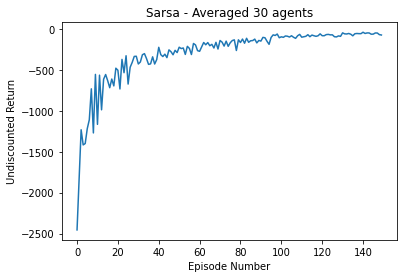

In [5]:
# Please write your code for Exercise 2 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your sarsa agent and plot your average learning curve here.
# Do NOT delete this cell.

import numpy as np
from racetrack_env import RacetrackEnv
from typing import List
from collections import defaultdict


def argmax(values: list) -> int:
    # np.argmax returns the first element in a list with the max value.
    # We dont want this. we want to get a random choice of this max val.
    max_val = max(values)
    actions = [a for a in range(len(values)) if values[a] == max_val]
    return np.random.choice(actions)


class EpsilonGreedyPolicy:
    def __init__(self, Q: dict, actions: List[int], epsilon: float) -> None:
        self._actions = actions
        self.Q = Q
        self.epsilon = epsilon

    def __call__(self, state: int) -> int:
        """
        Returns the optimal choice with probability of 1-epsilon. Else random.
        """
        probabilities = [(self.epsilon / len(self._actions)) for _ in self._actions]
        greedy_action = argmax(self.Q[state])
        probabilities[greedy_action] += (1 - self.epsilon)
        return np.random.choice(self._actions, p=probabilities)


class SarsaOnPolicyTDControl:
    def __init__(self, env, epsilon: float, gamma: float, alpha: float, num_episodes: int) -> None:
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.Q = defaultdict(lambda: [0 for _ in self.env.get_actions()])
        self.policy = EpsilonGreedyPolicy(self.Q, env.get_actions(), epsilon)

    def _do_episode(self):
        state = self.env.reset()
        episode = []
        action = self.policy(state)
        while True:
            next_state, reward, is_terminal = self.env.step(action)
            next_action = self.policy(next_state)
            episode.append((state, action, reward))
            self.Q[state][action] += self.alpha * (
                    reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
            state = next_state
            action = next_action
            if is_terminal:
                break
        return episode

    def start(self):
        undiscounted_rewards = []
        for episode_num in range(self.num_episodes):
            episode = self._do_episode()
            undiscounted_rewards.append(sum([step[2] for step in episode]))
        return undiscounted_rewards


num_agents = 30
alpha = 0.2
epsilon = 0.15  # chance of doing something random
gamma = 0.9  # discount
num_episodes = 150
optimal_policies = []
agents_rewards_list = []
for i in range(num_agents):
    env = RacetrackEnv()
    agent = SarsaOnPolicyTDControl(env, epsilon, gamma, alpha, num_episodes)
    rewards = agent.start()
    agents_rewards_list.append(rewards)

mean_agent_rewards = []
for i in range(num_episodes):
    sum_i = 0
    for agent_rewards in agents_rewards_list:
        sum_i += agent_rewards[i]
    reward_avg = sum_i / num_agents
    mean_agent_rewards.append(reward_avg)

print('-----------------')
print(mean_agent_rewards)
ex2_results = mean_agent_rewards

import matplotlib.pyplot as plt
plt.plot(mean_agent_rewards)
plt.title(f"Sarsa - Averaged {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.show()

## Exercise 3: Q-Learning (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Q-Learning agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Hint: Your Q-Learning implementation is likely to be similar to your Sarsa implementation. Think hard about where these two algorithms differ.

-----------------
[-2273.5333333333333, -1290.4333333333334, -1782.9666666666667, -1635.5666666666666, -1502.9, -1194.8666666666666, -1203.2333333333333, -821.0666666666667, -939.2666666666667, -1062.7, -827.0, -817.8333333333334, -769.8666666666667, -1017.2666666666667, -552.3, -721.9333333333333, -491.06666666666666, -792.8333333333334, -593.2, -508.53333333333336, -435.46666666666664, -469.6333333333333, -407.6333333333333, -426.93333333333334, -500.9, -549.6666666666666, -413.6333333333333, -373.26666666666665, -290.1, -310.43333333333334, -454.53333333333336, -384.53333333333336, -334.23333333333335, -261.43333333333334, -360.76666666666665, -293.06666666666666, -243.16666666666666, -277.06666666666666, -295.03333333333336, -294.06666666666666, -193.3, -288.8, -235.23333333333332, -247.33333333333334, -151.13333333333333, -160.96666666666667, -256.93333333333334, -148.73333333333332, -164.43333333333334, -169.63333333333333, -208.23333333333332, -88.86666666666666, -150.2666666666

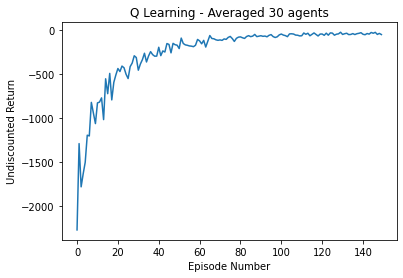

In [6]:
# Please write your code for Exercise 3 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

import numpy as np
from racetrack_env import RacetrackEnv
from typing import List
from collections import defaultdict


def argmax(values: list) -> int:
    # np.argmax returns the first element in a list with the max value.
    # We dont want this. we want to get a random choice of this max val.
    max_val = max(values)
    actions = [a for a in range(len(values)) if values[a] == max_val]
    return np.random.choice(actions)


class EpsilonGreedyPolicy:
    def __init__(self, Q: dict, actions: List[int], epsilon: float) -> None:
        self._actions = actions
        self.Q = Q
        self.epsilon = epsilon

    def argmax(self, state: int) -> int:
        # np.argmax returns the first element in a list with the max value.
        # We dont want this. we want to get a random choice of this max val.
        max_val = max(self.Q[state])
        actions = [a for a in self._actions if self.Q[state][a] == max_val]
        return np.random.choice(actions)

    def __call__(self, state: int) -> int:
        """
        Returns the optimal choice with probability of 1-epsilon. Else random.
        """
        probabilities = [(self.epsilon / len(self._actions)) for _ in self._actions]
        greedy_action = argmax(self.Q[state])
        probabilities[greedy_action] += (1 - self.epsilon)
        return np.random.choice(self._actions, p=probabilities)


class QLearning:
    def __init__(self, env, epsilon: float, gamma: float, alpha: float, num_episodes: int) -> None:
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.Q = defaultdict(lambda: [0 for _ in self.env.get_actions()])
        self.policy = EpsilonGreedyPolicy(self.Q, env.get_actions(), epsilon)

    def _do_episode(self):
        state = self.env.reset()
        episode = []
        while True:
            action = self.policy(state)
            next_state, reward, is_terminal = self.env.step(action)
            episode.append((state, action, reward))
            best_action = max(self.Q[next_state])
            self.Q[state][action] += self.alpha * (reward + self.gamma * best_action - self.Q[state][action])
            state = next_state
            if is_terminal:
                break
        return episode

    def start(self):
        undiscounted_rewards = []
        for episode_num in range(self.num_episodes):
            episode = self._do_episode()
            undiscounted_rewards.append(sum([step[2] for step in episode]))
        return undiscounted_rewards


num_agents = 30
alpha = 0.2
epsilon = 0.15  # chance of doing something random
gamma = 0.9  # discount
num_episodes = 150
optimal_policies = []
agents_rewards_list = []
for i in range(num_agents):
    env = RacetrackEnv()
    agent = QLearning(env, epsilon, gamma, alpha, num_episodes)
    rewards = agent.start()
    agents_rewards_list.append(rewards)

mean_agent_rewards = []
for i in range(num_episodes):
    sum_i = 0
    for agent_rewards in agents_rewards_list:
        sum_i += agent_rewards[i]
    reward_avg = sum_i / num_agents
    mean_agent_rewards.append(reward_avg)

print('-----------------')
print(mean_agent_rewards)
ex3_results = mean_agent_rewards

import matplotlib.pyplot as plt
plt.plot(mean_agent_rewards)
plt.title(f"Q Learning - Averaged {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.show()

## Exercise 4: Comparison & Discussion (8 Marks)

Please produce a plot which shows the data from your previous three graphs plotted together on the same set of axes. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

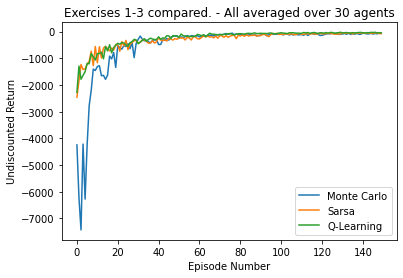

In [7]:
# Please write your code for Exercise 4 in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing each of the average learning curves of your three agents.
# Do NOT delete this cell.

import matplotlib.pyplot as plt
plt.plot(ex1_results, label="Monte Carlo")
plt.plot(ex2_results, label="Sarsa")
plt.plot(ex3_results, label="Q-Learning")
plt.title(f"Exercises 1-3 compared. - All averaged over {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.legend(loc=4)
plt.show()

In **eight sentences** or fewer, please discuss the following:
- The performance of your different agents.
- Why each of your agents performed differently.
- Explain the differences you saw, and expected to see, between the performances and polices of your Sarsa and Q-Learning agents.
- What could be done to improve the performance of your agents?

Monte Carlo control (MC) has a much slower initial learning curve when compared to both SARSA and Q-learning TD approaches. This is because unlike TD approaches, MC cannot learn without reaching the terminal goal state and is what causes the more negative undiscounted return for MC when compared to SARSA and Q-learning, especially in early episodes while it is acting almost completely randomly. Additionally, its state-action pairs are only updated using the final reward, and neighbouring states are not taken into account.

Sarsa and Q-learning benefit from quicker learning when compared to Monte-Carlo as they do not need to wait for an episode to terminate to update their state-action pair value function, Q(s, a). However, SARSA unlike Q-learning, uses on-policy learning by choosing its new action, a' using the same epsilon-greedy policy that was used to choose initial action, a. Because of this difference, and the fact that we aren't reducing epsilon over time, SARSA converged on the safer optimal epsilon-greedy policy, whereas Q-learning picked its next action greedily off-policy and learnt the optimal policy (optimal path). This difference can be observed in the slightly more negative and stochastic mean undiscounted return for SARSA in all episodes. An improvement all agents could benefit from is gradually reducing epsilon over time, which would limit exploration from taking place and encourage exploitation in later episodes once convergence to an optimal policy (epsilon greedy optimal in the case of SARSA) has mostly finished.

## Exercise 5: Modified Q-Learning Agent (16 Marks)
### Exercise 5a: Implementation
In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

In order to score high marks in this exercise, you will need to extend your solution beyond a simple Q-Learning agent to achieve more efficient learning (i.e., using fewer interactions with the environment). Ideas for improving your agent will have been discussed in lectures, and can be found in the course textbook (Reinforcement Learning, Sutton & Barto, 2018). However you go about improving your agent, it must still use **tabular Q-Learning** at its core.

Please produce the following:
- A tabular **Q-Learning agent**, with whatever modifications you believe are reasonable in order to acheieve better performance in the Racetrack domain.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 2.

**If you use incorrect parameters, you may not get any credit for your work.**

You may adjust all other parameters as you see fit.

-----------------


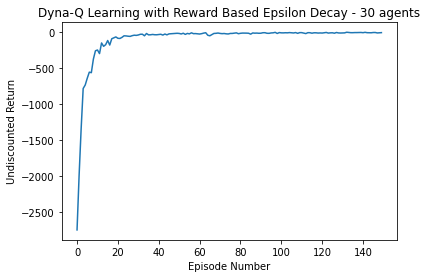

In [8]:
# Please write your code for Exercise 5a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

import random
import abc
import numpy as np
from racetrack_env import RacetrackEnv
from typing import List, Union
from collections import defaultdict


def argmax(values: list) -> int:
    # np.argmax returns the first element in a list with the max value.
    # We dont want this. we want to get a random choice of this max val.
    max_val = max(values)
    actions = [a for a in range(len(values)) if values[a] == max_val]
    return np.random.choice(actions)


class Epsilon:
    def __init__(self, initial: Union[int, float]):
        self.value = initial

    @abc.abstractmethod
    def update(self, reward: Union[int, float]) -> Union[int, float]:
        ...


class RewardBasedDecayEpsilon(Epsilon):
    def __init__(self,
                 initial: Union[int, float],
                 minimum: Union[int, float],
                 decay_factor: Union[int, float],
                 reward_threshold: int,
                 reward_increment: int) -> None:
        super().__init__(initial)
        self.minimum = minimum
        self.decay_factor = decay_factor
        self.reward_threshold = reward_threshold
        self.reward_increment = reward_increment

    def update(self, reward: Union[int, float]) -> Union[int, float]:
        if self.value > self.minimum and reward >= self.reward_threshold:
            self.value *= self.decay_factor
            self.reward_threshold += self.reward_increment
        return self.value


class EpsilonGreedyPolicy:
    def __init__(self, Q: dict, actions: List[int], epsilon: Epsilon) -> None:
        self._actions = actions
        self.Q = Q
        self.epsilon = epsilon

    def __call__(self, state: int) -> int:
        """
        Returns the optimal choice with probability of 1-epsilon. Else random.
        """
        probabilities = [(self.epsilon.value / len(self._actions)) for _ in self._actions]
        greedy_action = argmax(self.Q[state])
        probabilities[greedy_action] += (1 - self.epsilon.value)
        return np.random.choice(self._actions, p=probabilities)


class QLearning:
    def __init__(self, env, epsilon: Epsilon, gamma: float, alpha: float, num_episodes: int) -> None:
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.Q = defaultdict(lambda: [0 for _ in self.env.get_actions()])
        self.policy = EpsilonGreedyPolicy(self.Q, env.get_actions(), epsilon)
        self.model = defaultdict(dict)

    def _do_episode(self, episode_num):
        state = self.env.reset()
        episode = []
        while True:
            action = self.policy(state)
            next_state, reward, is_terminal = self.env.step(action)
            episode.append((state, action, reward))
            best_action = max(self.Q[next_state])
            self.Q[state][action] += self.alpha * (reward + self.gamma * best_action - self.Q[state][action])
            self.model[state][action] = (reward, next_state)

            for i in range(20):
                s = random.choice(list(self.model))
                a = random.choice(list(self.model[s]))
                r, s_ = self.model[s][a]
                a1 = max(self.Q[s_])
                self.Q[s][a] += self.alpha * (r + self.gamma * a1 - self.Q[s][a])

            state = next_state
            if is_terminal:
                break
        return episode

    def start(self):
        undiscounted_rewards = []
        for episode_num in range(self.num_episodes):
            episode = self._do_episode(episode_num)
            undiscounted_reward = sum([step[2] for step in episode])
            undiscounted_rewards.append(undiscounted_reward)
            self.epsilon.update(sum([step[2] for step in episode]))
        return undiscounted_rewards


num_agents = 30
alpha = 0.2
gamma = 0.9  # discount
num_episodes = 150
optimal_policies = []
agents_rewards_list = []
for i in range(num_agents):
    env = RacetrackEnv()
    epsilon = RewardBasedDecayEpsilon(initial=0.4,
                                      minimum=0.0,
                                      decay_factor=0.93,
                                      reward_threshold=-200,
                                      reward_increment=3
                                      )
    agent = QLearning(env, epsilon, gamma, alpha, num_episodes)
    rewards = agent.start()
    agents_rewards_list.append(rewards)

mean_agent_rewards = []
for i in range(num_episodes):
    sum_i = 0
    for agent_rewards in agents_rewards_list:
        sum_i += agent_rewards[i]
    reward_avg = sum_i / num_agents
    mean_agent_rewards.append(reward_avg)

print('-----------------')
ex5_results = mean_agent_rewards
import matplotlib.pyplot as plt

plt.plot(mean_agent_rewards)
plt.title(f"Dyna-Q Learning with Reward Based Epsilon Decay - {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.show()

### Exercise 5b: Comparison & Discussion

Please produce a plot which shows the performance of your original Q-Learning agent and your modified Q-Learning agent. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

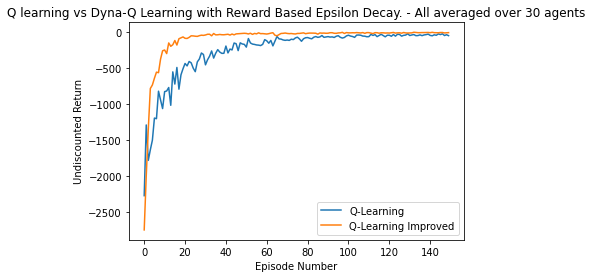

In [9]:
# Please write your code for Exercise 5b in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing the average learning curves of your
# original and modified Q-Learning agents.
# Do NOT delete this cell.

import matplotlib.pyplot as plt
plt.plot(ex3_results, label="Q-Learning")
plt.plot(ex5_results, label="Q-Learning Improved")
plt.title(f"Q learning vs Dyna-Q Learning with Reward Based Epsilon Decay. - All averaged over {num_agents} agents")
plt.xlabel("Episode Number")
plt.ylabel("Undiscounted Return")
plt.legend(loc=4)
plt.show()

In **eight sentences** or fewer, please discuss the following:
- The modifications that you have made to your agent beyond implementing basic Q-Learning.
- The effects you expected your additions to have, and the extent to which your expectations were met.
- Further modifications you believe may enhance the performance of your agent, or changes you would make if you had more time.

Please note that **your implementation and discussion will be assessed jointly**. This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

In my improved Q-Learning approach, I implemented a combination of Dyna-Q learning and reward-based epsilon decay, where the latter reduces exploration over time and in turn, encourages the agent to act more greedily based on information it has since learnt. In my implementation, the rate of decay is based off various factors including a decay rate to multiply epsilon by after each episode, a reward threshold which must be met before starting decay, and a reward increment which increases the reward threshold over time. The more negative discounted reward value in early episodes can be explained by the high starting epsilon value which encourages early learning over exploitation. This epsilon ends up tending towards 0, whereby exploitation of knowledge learnt is exploited and is therefore more representative the optimal policy.

Dyna-Q is the implementation of both direct reinforcement learning (what the regular one-step tabular Q-learning does) and model learning, which has the benefit of learning not only from real experience, but also simulated experience. In the model learning phase, we loop n amount of times, randomly picking a state-action pair we have previously explored and update our Q value function with the next state and reward as its prediction.


While these methods exceeded all my initial expectations, I would have additionally liked to experiment with implementing prioritised sweeping, whereby instead of sampling randomly from previously experienced state-action pairs, we explore these pairs in order of priority. This method has the obvious benefit of being more efficient, and in general, we prioritise backwards from the terminal goal state (backward focused), as these states have the greatest reward.